In [ ]:
'''
Objectives: 
Create a model to classify DNA sequences based on
their likelihood to bind to the transcription factor (TF) CTCF.
Feature scaling, hyperparameter search using GridSearchCV,
and evaluate the models’ performance using the Area Under the ROC Curve (AUROC).
Model Info: 
Model will train on simulated datasets derived from ChIP-seq peaks alongside non-binding sequences
Model Type: 
Logistic regression with L2 regularization
Naive Bayes to explore and compare different approaches
'''

In [1]:
# import block 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # for plotting AUC
import textwrap

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import  GaussianNB



In [2]:
# PART 1: FEATURE EXTRACTION

In [3]:
# import files
# DNA sequences that bind to CTCF
file_path = '/Users/peytonhall/downloads/assignment_03/ctcf_bound_sequence.txt'
seqBound = pd.read_csv(file_path, sep='\t', header=None)
seqBound
# label as y = 1

# DNA sequences that DO NOT bind to CTCF
file_path = '/Users/peytonhall/downloads/assignment_03/ctcf_unbound_sequence.txt'
seqUnbound = pd.read_csv(file_path, sep='\t', header=None)
seqUnbound
# label as y = 0

,0
0,TTTATTGACCACCTAGAAGCGGTTTGGCGT
1,GGAAGGTCCCACCAGGCGGAACCGCAATAT
2,GATCATGGCCACCTGGGGGGAACATTACGC
3,TGATTTAGGCACTAGAGGGCCCTGTAAGCC
4,AAATCCTACCACTTGAGGGCGGGCCGGGAT
...,...
1995,ATTCCCCGCCACCAGCTGGCGTCAGGGACA
1996,GTGGTAGGCCATCAGAGGTCGATGGCGTCT
1997,GGGCGCCTGCAGCAGGTGACAGATTACGCT
1998,GGGCTCGGCGAGTCGTTTGCGATGAGAGCC


In [4]:
# import shape files 
# Download the corresponding shape files for four DNA shape features
# Minor Groove Width, Propeller Twist, Roll, Helical Twist

# Import Bound
file_path = '/Users/peytonhall/downloads/assignment_03/ctcf_bound.HelT'
boundHel = pd.read_csv(file_path, sep='\t', header=None)
boundHel = boundHel[0].str.split(" ", expand=True)
boundHel = boundHel.apply(pd.to_numeric)
boundHel

file_path = '/Users/peytonhall/downloads/assignment_03/ctcf_bound.MGW'
boundMGW = pd.read_csv(file_path, sep='\t', header=None)
boundMGW = boundMGW[0].str.split(" ", expand=True)
boundMGW = boundMGW.apply(pd.to_numeric)
boundMGW

file_path = '/Users/peytonhall/downloads/assignment_03/ctcf_bound.ProT'
boundPro = pd.read_csv(file_path, sep='\t', header=None)
boundPro = boundPro[0].str.split(" ", expand=True)
boundPro = boundPro.apply(pd.to_numeric)
boundPro

file_path = '/Users/peytonhall/downloads/assignment_03/ctcf_bound.Roll'
boundRoll = pd.read_csv(file_path, sep='\t', header=None)
boundRoll = boundRoll[0].str.split(" ", expand=True)
boundRoll = boundRoll.apply(pd.to_numeric)
boundRoll

# Import Unbound
file_path = '/Users/peytonhall/downloads/assignment_03/ctcf_unbound.HelT'
unboundHel = pd.read_csv(file_path, sep='\t', header=None)
unboundHel = unboundHel[0].str.split(" ", expand=True)
unboundHel = unboundHel.apply(pd.to_numeric)
unboundHel

file_path = '/Users/peytonhall/downloads/assignment_03/ctcf_unbound.MGW'
unboundMGW = pd.read_csv(file_path, sep='\t', header=None)
unboundMGW = unboundMGW[0].str.split(" ", expand=True)
unboundMGW = unboundMGW.apply(pd.to_numeric)
unboundMGW

file_path = '/Users/peytonhall/downloads/assignment_03/ctcf_unbound.ProT'
unboundPro = pd.read_csv(file_path, sep='\t', header=None)
unboundPro = unboundPro[0].str.split(" ", expand=True)
unboundPro = unboundPro.apply(pd.to_numeric)
unboundPro

file_path = '/Users/peytonhall/downloads/assignment_03/ctcf_unbound.Roll'
unboundRoll = pd.read_csv(file_path, sep='\t', header=None)
unboundRoll = unboundRoll[0].str.split(" ", expand=True)
unboundRoll = unboundRoll.apply(pd.to_numeric)
unboundRoll

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
0,-2.138866,-1.188803,8.144425,-3.594348,-1.857451,6.803225,-0.611546,-2.271277,-0.679316,2.357328,...,1.939955,-0.891714,-3.793289,-3.715151,-3.074820,2.972331,-1.409185,-2.017498,4.231595,-2.051757
1,-1.302453,-0.268893,-3.940038,-3.939700,-3.015928,-4.588016,-2.779263,-1.039200,-2.007505,2.045589,...,-3.643554,-2.861020,-0.502418,2.454390,-1.127386,4.390614,-2.874587,-4.188812,7.345188,-2.858780
2,-0.599531,-4.394622,-1.070906,4.988440,-4.006577,3.526304,-1.787354,-2.079422,-1.477624,2.200573,...,-1.007394,-3.901558,-3.668811,5.711183,-5.205194,-2.060240,6.222474,-2.413164,3.972157,-1.768682
3,4.019381,-0.192562,-4.753694,-2.149995,-0.837322,6.614321,-2.326235,-1.738418,-1.875802,2.850543,...,-2.238098,-2.130540,-2.812258,3.697177,-2.020011,6.100336,-2.466852,-2.647687,-3.007220,-2.114107
4,1.232321,-2.421489,-7.016572,-2.424993,-1.620575,-2.987259,3.488762,-2.473886,-0.756519,2.728051,...,1.379277,-1.750595,-1.580441,-1.955026,-1.489836,1.836110,-1.679136,-1.077042,-0.993061,-4.121867
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,-4.596695,-3.388017,-1.148492,-1.454612,-2.092157,-1.830902,1.591822,-1.716677,-1.213729,2.552442,...,3.374193,-2.423626,-1.170169,4.213751,-2.806761,-2.416383,-0.749644,-1.886643,-2.492170,5.000802
1996,-1.952929,3.597276,-0.659843,-2.456631,3.297228,-2.844787,-1.933930,-2.578702,-1.987648,3.693495,...,5.058935,-0.005732,-3.783879,3.356137,-1.896326,-2.083890,3.185255,-2.864871,-1.486886,-0.007294
1997,-1.890534,-1.500420,-1.703959,2.043182,-2.095430,-1.749877,-2.046567,3.445784,-0.961530,3.389671,...,3.501926,-1.894808,-0.730937,-5.563169,-2.478316,5.558130,-2.429001,3.562737,-2.110448,-0.875049
1998,-1.969470,-1.877403,-2.659123,-2.582295,-1.189514,4.403155,-0.844865,-1.530300,3.505199,-1.379821,...,4.869134,-0.381406,-4.299625,5.046129,-1.478917,-1.756180,-1.437251,-2.640308,-2.548122,-1.925925


In [5]:
# combine bound and unbound to get 4 shape features
# shape is (2000, 58)
shapeHel = np.vstack((boundHel, unboundHel))
shapeRoll = np.vstack((boundRoll, unboundRoll))

# shape is (2000, 60)
shapeMGW = np.vstack((boundMGW, unboundMGW))
shapePro = np.vstack((boundPro, unboundPro))

In [6]:
print(shapeHel.shape)
print(shapeHel)

(4000, 29)
[[32.299187 33.76005  33.494972 ... 35.126404 34.64012  33.768417]
 [33.414623 34.59502  32.295177 ... 33.423203 36.39585  33.108578]
 [34.252808 36.297737 31.832935 ... 34.825424 32.92126  36.794247]
 ...
 [33.01091  33.6706   36.223522 ... 33.030476 37.342247 31.655994]
 [33.029263 33.364998 36.81955  ... 31.570007 37.009323 32.886414]
 [33.908745 31.806595 34.868828 ... 32.158882 33.550858 33.78866 ]]


In [7]:
# make min-max normalization function
def normalizationFunct(shape):
    minShape = shape.min()
    maxShape = shape.max()
    y = [(x - minShape) / (maxShape - minShape) for x in shape]
    y = shape - minShape / (maxShape - minShape)
    y = np.array(y)
    return y

In [8]:
# normalize each feature to scale them from 0 to 1
# shape is (4000, 29)
normalHel = normalizationFunct(shapeHel)
normalRoll = normalizationFunct(shapeRoll)

# shape is (4000, 30)
normalMGW = normalizationFunct(shapeMGW)
normalPro = normalizationFunct(shapePro)

In [9]:
print(normalHel)

[[29.0236466 30.4845096 30.2194316 ... 31.8508636 31.3645796 30.4928766]
 [30.1390826 31.3194796 29.0196366 ... 30.1476626 33.1203096 29.8330376]
 [30.9772676 33.0221966 28.5573946 ... 31.5498836 29.6457196 33.5187066]
 ...
 [29.7353696 30.3950596 32.9479816 ... 29.7549356 34.0667066 28.3804536]
 [29.7537226 30.0894576 33.5440096 ... 28.2944666 33.7337826 29.6108736]
 [30.6332046 28.5310546 31.5932876 ... 28.8833416 30.2753176 30.5131196]]


In [29]:
# combine all 4 normalized features into an array
# shape is (4000, 118)
normalShape = np.hstack((normalHel, normalRoll, normalMGW, normalPro))

In [30]:
# make one hot encode function for sequences
def encodeMono(sequence):
    monoMap = {"A": [1, 0, 0, 0], "C": [0, 1, 0, 0], "G": [0, 0, 1, 0], "T": [0, 0, 0, 1]}
    encoded = []
    for mononucleotide in sequence:
        encoded.extend(monoMap[mononucleotide])
    return encoded

In [31]:
# apply encoding function to bound sequence
# shape is (2000, 120)
preBound = seqBound[0].tolist()
encodeBound = np.array([encodeMono(seq) for seq in preBound])

# apply encoding function to unbound sequence
# shape is (2000, 120)
preUnBound = seqUnbound[0].tolist()
encodeUnBound = np.array([encodeMono(seq) for seq in preUnBound])

In [32]:
# combine bound and unbound to make array
# shape is (4000, 120)
monoMer = np.vstack((encodeBound, encodeUnBound))

In [33]:
# make x var for model (this is encoded bound/unbound sequence (1mer) + 
# the normalized shape of the four features array (shape))
# shape is (4000, 238)
xVar = np.hstack((monoMer, normalShape))

In [34]:
# PART 2: LOGISTIC REGRESSION WITH GRID SEARCH
print(xVar)

[[  0.           1.           0.         ...  -7.29922271  -4.47830631
    3.00085359]
 [  0.           0.           1.         ...  -3.14050241  -1.50836041
    2.78243449]
 [  0.           0.           0.         ...  -1.65218991 -11.93843771
  -16.42134271]
 ...
 [  0.           0.           1.         ...  -3.60481121  -0.99897331
   -9.33499071]
 [  0.           0.           1.         ...   0.10027052  -1.44209291
    3.30405189]
 [  0.           1.           0.         ...  -3.34621071  -3.68847801
   -3.41273071]]


In [12]:
# make y var for model
boundYLab = [1] * 2000
boundYLab = np.array(boundYLab)
unBoundYLab = [0] * 2000
unBoundYLab = np.array(unBoundYLab)

# shape is (4000,)
totalYLab = np.hstack((boundYLab, unBoundYLab))

In [ ]:
'''Train a logistic regression model with L2 regularization on the combined feature set
(1mer+shape) for CTCF. '''

In [13]:
def logRegGFunct(X, y):
    # Split the data into training and testing sets (80%-20%)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

    # Set up the logistic regression model with L2 regularization
    logistic_model = LogisticRegression(penalty='l2', max_iter=5000, solver='lbfgs')

    # Define the parameter grid for C
    param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

    # Set up GridSearchCV for hyperparameter tuning
    grid_search = GridSearchCV(estimator=logistic_model, param_grid=param_grid, 
                               scoring='roc_auc', cv=5, verbose=1)

    # Train the model using GridSearchCV
    grid_search.fit(X_train, y_train)

    # Best model from grid search
    best_model = grid_search.best_estimator_

    # Make predictions on the test set
    y_pred_prob = best_model.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class

    # Calculate the Area Under the ROC Curve (AUROC)
    auroc = roc_auc_score(y_test, y_pred_prob)

    # Print the results
    print("Best C parameter from GridSearchCV:", grid_search.best_params_)
    print("AUROC on test set:", auroc)
    
    return y_test, y_pred_prob

In [148]:
# PART 3: NAIVE BAYES CLASSIFIER

In [14]:
# naive bayes classifier
def naiveBayeFunct(X, y):
    # Configure the cross-validation
    X_train, X_test, y_train, y_test= train_test_split(X, y, test_size= 0.2, train_size= 0.8, shuffle=True)
    # Initialize Naive Bayes Classifier model
    model = GaussianNB()
    # Fit model with training data
    model.fit(X_train, y_train)
    
    # get probabilities on a positive class
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    # Predict on valid set
    predictions = model.predict(X_test)
    
    # Evaluate the model
    mse = mean_squared_error(y_test, predictions)

    r_squared = model.score(X_test, y_test)

    # Evaluate the model
    AUC= roc_auc_score(y_test, y_pred_prob)
    
    # Print the results
    print("AUC = ", AUC)
    print("MSE = ", mse)
    print("r_squared = ", r_squared)
    
    return y_test, y_pred_prob

In [15]:
# get output from both models
y_test_lr, y_pred_prob_lr = logRegGFunct(xVar, totalYLab)
y_test_nb, y_pred_prob_nb = naiveBayeFunct(xVar, totalYLab)

# sample output from one run: 

# Linear Regression: 
    # Best C parameter from GridSearchCV: {'C': 0.1}
    # AUROC on test set: 0.9535795337322055

# Naive Bayes:
    # AUC =  0.9448341836734694
    # MSE =  0.13125
    # r_squared =  0.86875

Fitting 5 folds for each of 6 candidates, totalling 30 fits


/Users/peytonhall/miniconda3/envs/qbio_490_pbhall/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Best C parameter from GridSearchCV: {'C': 0.1}
AUROC on test set: 0.9535795337322055
AUC =  0.9409106556094508
MSE =  0.12875
r_squared =  0.87125


In [ ]:
# PART 4: PERFORMANCE COMPARISON

In [16]:
def aurocPlot(y_test_lr, y_pred_prob_lr, y_test_nb, y_pred_prob_nb):
    # Calculate ROC curve and AUC for Logistic Regression
    fpr_lr, tpr_lr, _ = roc_curve(y_test_lr, y_pred_prob_lr)
    auc_lr = roc_auc_score(y_test_lr, y_pred_prob_lr)
    # Calculate ROC curve and AUC for Naive Bayes
    fpr_nb, tpr_nb, _ = roc_curve(y_test_nb, y_pred_prob_nb)
    auc_nb = roc_auc_score(y_test_nb, y_pred_prob_nb)
    
    # plot details
    plt.figure(figsize=(10, 8), dpi=100)
    plt.plot(fpr_lr, tpr_lr, color='blue', label=f'Logistic Regression (AUC = {auc_lr:.4f})')
    plt.plot(fpr_nb, tpr_nb, color='red', label=f'Naive Bayes (AUC = {auc_nb:.4f})')
    plt.fill_between(fpr_lr, tpr_lr, color='lightblue', alpha=0.5)
    plt.fill_between(fpr_nb, tpr_nb, color='pink', alpha=0.5)
    
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.title("AUC & ROC Curve Comparison")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

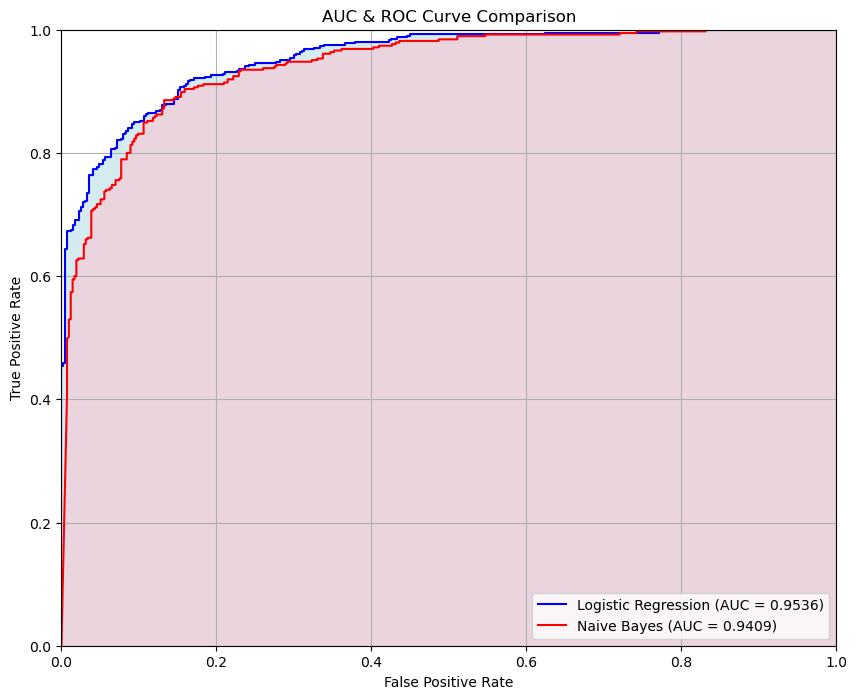

In [17]:
# Generate the AUROC plot
aurocPlot(y_test_lr, y_pred_prob_lr, y_test_nb, y_pred_prob_nb)

In [ ]:
'''
According to the plot, it seems that logistic regression performed
better than naive bayes. Both models performed well, since they both seem to hug 
the top left corner suggesting a high true positive rate and low false 
positivity rate. The AUC of the logistic regression with grid search was 
0.9536 and the AUC of the naive bayes model was 0.9409.
'''